# Bird Call recognition
### The task is to make a model which can effectively predict the voice of a specific bird called Capuchin_Bird. I came over this problem when exploring the Z-HP-Unlocked website. It is quite a interesting problem and the solution is even more so.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_io as tfio
import numpy as np
import seaborn as sns
import os
from itertools import groupby

In [2]:
def decode_audio(filepath):
    audio = tf.io.read_file(filepath)
    audio, sample_rate = tf.audio.decode_wav(audio, desired_channels = 1)
    audio = tf.squeeze(audio)
    sample_rate = tf.cast(sample_rate, tf.int64)
    audio = tfio.audio.resample(audio, rate_in = sample_rate, rate_out = 16000)
    
    return audio

In [3]:
def preprocess_audio(decoded):
    limit = 40000
    zeroes = 0 if limit - len(decoded) < 0 else limit - len(decoded)
    zeroes = tf.zeros(zeroes)
    
    decoded = tf.concat([zeroes, decoded], axis = 0)
    decoded = decoded[:limit]
    
    spectrogram = tf.signal.stft(decoded, 255, 128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    
    return spectrogram

In [4]:
bird_path = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips'
not_bird_path = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips'

bird_files = tf.io.gfile.glob(bird_path + '/*.wav')
not_bird_files = tf.io.gfile.glob(not_bird_path + '/*.wav')

files = tf.concat([bird_files, not_bird_files], axis = 0)

In [5]:
def get_label(filepath):
    parts = tf.strings.split(input=filepath,sep=os.path.sep)
    return parts[-2]

def decode_and_label(filepath):
    label = get_label(filepath)
    decoded_audio = decode_audio(filepath)
    
    return decoded_audio, label

In [6]:
files_data = tf.data.Dataset.from_tensor_slices(files)
labelled_and_decoded_data = files_data.map(decode_and_label)

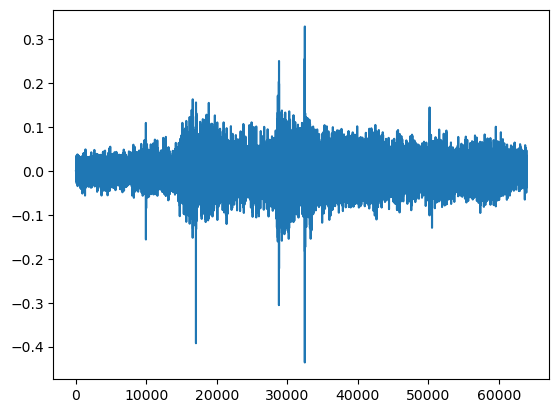

In [7]:
for i, (audio, label) in enumerate(labelled_and_decoded_data.take(1)):
    plt.plot(audio)

In [8]:
def preprocess_and_label(decoded, label):
    decoded_label = tf.argmax(label == ['Parsed_Not_Capuchinbird_Clips', 'Parsed_Capuchinbird_Clips'])
    preprocessed_audio = preprocess_audio(decoded)
    return preprocessed_audio, decoded_label

In [9]:
data = labelled_and_decoded_data.map(preprocess_and_label)

tf.Tensor([311 129   1], shape=(3,), dtype=int32)
tf.Tensor(1, shape=(), dtype=int64)


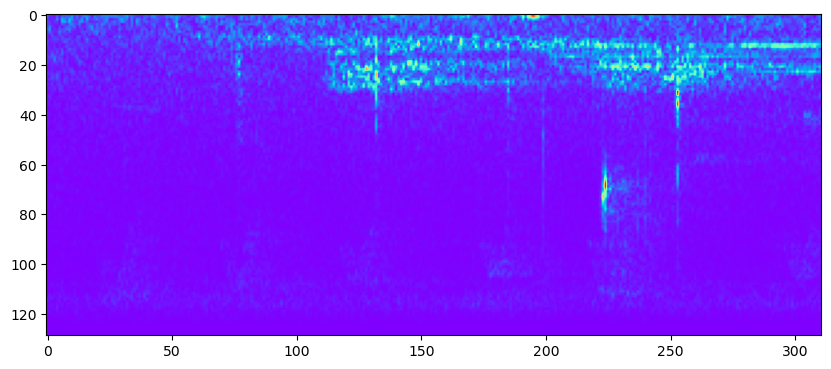

In [10]:
plt.figure(figsize = (10, 20))
for i, (spectrogram, label) in enumerate(data.take(1)):
    plt.imshow(tf.transpose(spectrogram)[0], cmap = 'rainbow')
    print(tf.shape(spectrogram))
    print(label)
    

In [11]:
data = data.shuffle(10000)
test_len = int(len(data) * 0.1)

test_data = data.take(test_len)
train_data = data.skip(test_len).batch(32)

In [12]:
def return_only_spectrogram(spectrogram, label):
    return spectrogram

In [13]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data = data.map(return_only_spectrogram))

In [14]:
for spectrogram, _ in data.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (311, 129, 1)


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(input_shape),
    
    norm_layer,
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(16, (3, 3)),
    
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(16, (3, 3)),
    
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(2),
    
])


print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 311, 129, 1)      3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 309, 127, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 307, 125, 32)      18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 305, 123, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 97, 36, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 97, 36, 32)        0

In [16]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True,
)
history = model.fit(train_data, epochs = 20)

Epoch 1/20


2023-05-11 13:31:17.937009: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - 21s 132ms/step - loss: 0.4702 - accuracy: 0.8162
Epoch 2/20
23/23 [==============================] - 12s 111ms/step - loss: 0.3087 - accuracy: 0.8930
Epoch 3/20
23/23 [==============================] - 12s 110ms/step - loss: 0.2303 - accuracy: 0.9287
Epoch 4/20
23/23 [==============================] - 12s 111ms/step - loss: 0.1573 - accuracy: 0.9492
Epoch 5/20
23/23 [==============================] - 12s 110ms/step - loss: 0.1926 - accuracy: 0.9506
Epoch 6/20
23/23 [==============================] - 12s 111ms/step - loss: 0.2271 - accuracy: 0.9410
Epoch 7/20
23/23 [==============================] - 12s 110ms/step - loss: 0.1327 - accuracy: 0.9630
Epoch 8/20
23/23 [==============================] - 12s 110ms/step - loss: 0.1604 - accuracy: 0.9698
Epoch 9/20
23/23 [==============================] - 12s 110ms/step - loss: 0.0977 - accuracy: 0.9684
Epoch 10/20
23/23 [==============================] - 12s 110ms/step - loss: 0.0845 - accuracy: 0.9712


In [18]:
history = history.history
loss = history['loss'] 
acc = history['accuracy'] 

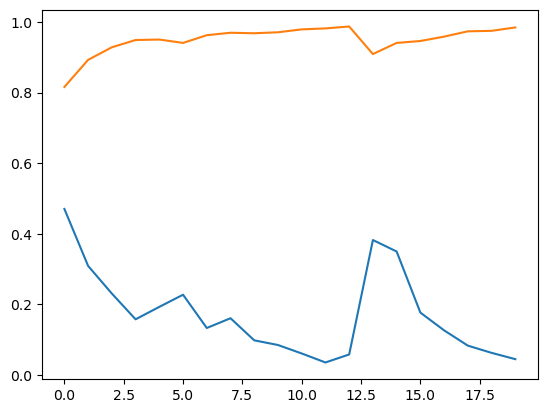

In [19]:
plt.plot(loss)
plt.plot(acc)

In [20]:
model.evaluate(test_data.batch(10))

9/9 [==============================] - 10s 14ms/step - loss: 0.0139 - accuracy: 1.0000


[0.013928420841693878, 1.0]

In [21]:
test_audio = []
test_labels = []

for audio, label in test_data:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

print(np.shape(test_audio))
print(np.shape(test_labels))

(81, 311, 129, 1)
(81,)


In [22]:
test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y = model.predict(test_audio)
y_pred = np.argmax(y, axis=1)
y_true = test_labels

print(np.shape(y_pred))
print(np.shape(y_true))

3/3 [==============================] - 0s 96ms/step
(81,)
(81,)


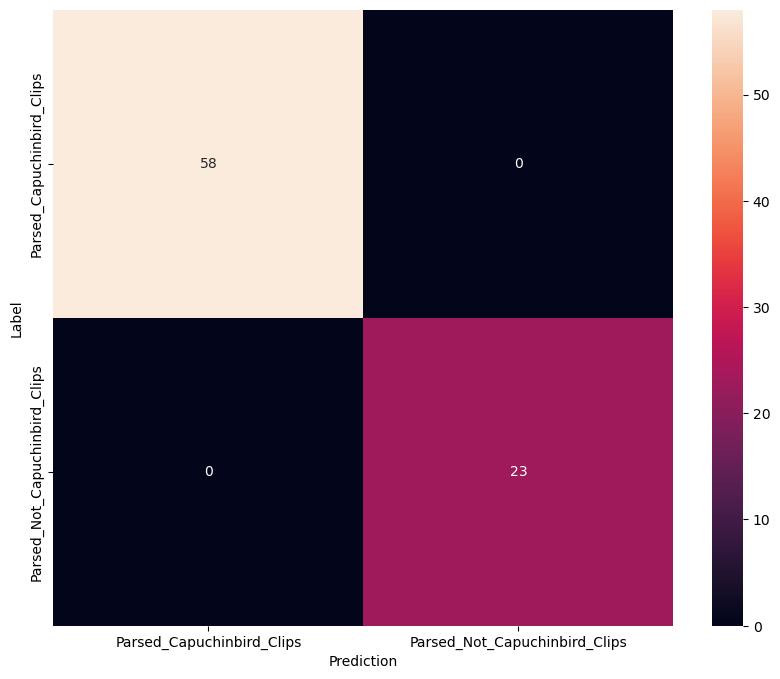

In [23]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
commands = ["Parsed_Capuchinbird_Clips","Parsed_Not_Capuchinbird_Clips"]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [24]:
forest_recordings = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings'
forest_recordings_files = os.listdir(forest_recordings)

In [25]:
forest_recs_full_paths = []
for file in forest_recordings_files:
    full_path = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings' + f'/{file}'
    forest_recs_full_paths.append(full_path)

In [26]:
# filepath = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_00.mp3"
def predict_forest_rec(filepath):
    audio = tfio.audio.AudioIOTensor(filepath)
    sample_rate = audio.rate

    audio = audio.to_tensor()
    audio = tf.math.reduce_sum(audio, axis = 1) / 2

    sample_rate = tf.cast(sample_rate, tf.int64)
    audio = tfio.audio.resample(audio, rate_in = sample_rate, rate_out = 16000)

    slices = tf.keras.utils.timeseries_dataset_from_array(audio, audio, 
                                                          sequence_length = 40000, 
                                                          sequence_stride = 40000, 
                                                          batch_size = 1)
    audio_slices = []
    for (data, index) in slices:
        audio_slices.append(tf.squeeze(data))

    audio_spectrograms = []
    for audio_slice in audio_slices:
        spectrogram = tf.signal.stft(audio_slice, 255, 128)
        spectrogram = tf.abs(spectrogram)
        spectrogram = tf.expand_dims(spectrogram, axis = 2)
        audio_spectrograms.append(spectrogram)

    y = model.predict(np.array(audio_spectrograms))
    y_pred = np.argmax(y, axis=1)

    predictions = []
    for i, group in groupby(y_pred):
        predictions.append(i)
        
    return predictions

In [27]:
forest_predictions = []
for file in forest_recs_full_paths[:5]:
    pred = predict_forest_rec(file)
    forest_predictions.append(pred)
    
forest_predictions

3/3 [==============================] - 0s 17ms/step


[[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
 [0],
 [0, 1, 0, 1, 0, 1, 0, 1, 0],
 [0, 1, 0],
 [0, 1, 0, 1, 0, 1, 0]]